# Download requirements

In [ ]:
install.packages('rugarch')
install.packages('forecast')

In [1]:
library(rugarch)
library(forecast)

Warning message:
"package 'rugarch' was built under R version 3.6.3"Loading required package: parallel
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma

Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Predict cho Utils portfolio

#### Lấy dữ liệu của Utils porfolio

In [5]:
series <- ts(data = data$Utils, start = c(1963,7), end = c(2022,4), frequency = 12) 

In [6]:
series %>% summary()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-13.0100  -1.4200   0.9150   0.8424   3.2775  18.8400 

#### Khảo sát tập train từ 7/1963 - 12/1989

In [7]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {100*(exp(x)-1)} #inverter

In [8]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale()

In [9]:
series_train %>% summary()

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.129995 -0.015799  0.004938  0.007690  0.031184  0.172608 

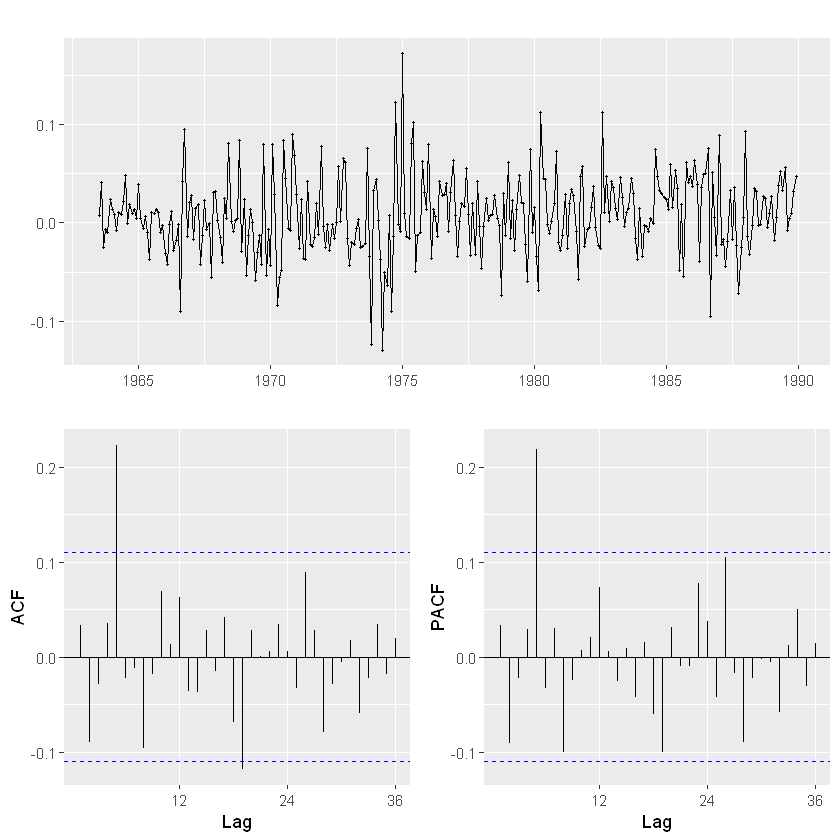

In [10]:
series_train %>% ggtsdisplay()

#### Chọn tham số cho mô hình ARMA-GARCH

In [11]:
garch_spec <- ugarchspec(mean.model = list(armaOrder = c(2,3), include.mean = TRUE), 
                         variance.model = list(model = "sGARCH", garchOrder = c(1,1)))

In [12]:
garch_fit <- ugarchfit(spec = garch_spec, data = series_train)
coef(garch_fit)

mu           ar1           ar2           ma1           ma2 
 0.0088580635  0.8713994483 -0.8354894950 -0.8658015595  0.7163085297 
          ma3         omega        alpha1         beta1 
 0.0555135464  0.0001224117  0.1056019847  0.8172355011

In [13]:
infocriteria(garch_fit)

,
Akaike,-3.653447
Bayes,-3.546974
Shibata,-3.654991
Hannan-Quinn,-3.610921


In [14]:
fitted <- ts(data = garch_fit@fit$fitted.values, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
true <- ts(data = garch_fit@model$modeldata$data, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv

In [15]:
(fitted - true)^2 %>% mean %>% sqrt

[1] 3.972874

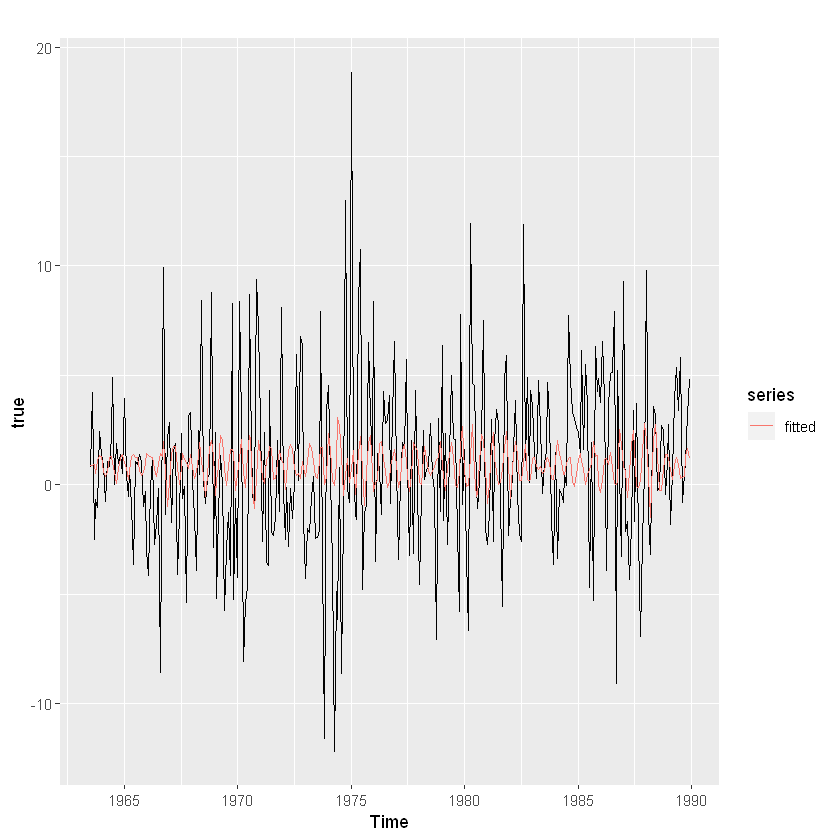

In [16]:
autoplot(true)+autolayer(fitted)

#### Predict rolling window trên tập test

In [17]:
garch_spec <- ugarchspec(mean.model = list(armaOrder = c(2,3), include.mean = TRUE), 
                         variance.model = list(model = "sGARCH", garchOrder = c(1,1)))
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end=length(series)-388+i) %>% log_scale()
    fit <- ugarchfit(spec = garch_spec, data = train)
    pred_val <- ugarchforecast(fit, n.ahead = 1)@forecast$seriesFor[1] %>% log_inv()
    pred <- c(pred, pred_val)
}
pred <- ts(pred, start=c(1990,1), frequency = 12)
true <- series %>% window(start=c(1990,1))
rmse <- sqrt(mean((true-pred)^2))

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = mo

In [18]:
rmse

[1] 3.999952

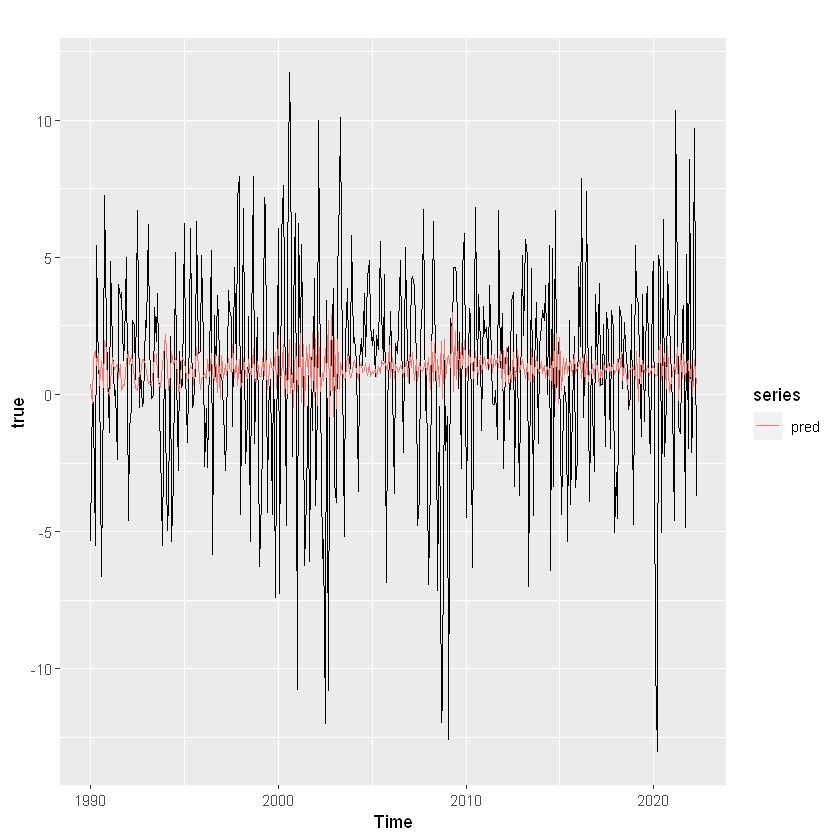

In [19]:
autoplot(true) + autolayer(pred)